# Download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
!mv /kaggle/input/brain-tumor-mri-dataset ./brain_tumor_mri_dataset_2/

# Import Libraries

In [ ]:
# Imports and metric utilities
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models


# Load Dataset

In [ ]:
# Define classes/paths and load images (grayscale 200x200) into X and y
classes = {"notumor": 0, "pituitary": 1, "meningioma": 2, "glioma": 3}
folders = ["/content/brain_tumor_mri_dataset_2/Training", "/content/brain_tumor_mri_dataset_2/Testing"]

x = []
y = []
sizes = []

for folder in folders:
    for cls in classes:
        pth = os.path.join(folder, cls)
        for img_name in os.listdir(pth):
            img = cv2.imread(os.path.join(pth, img_name), 0)
            sizes.append(img.shape)
            img = cv2.resize(img, (200,200))
            x.append(img)
            y.append(classes[cls])

x = np.array(x)
y = np.array(y)

print("Full dataset shape:", x.shape)
print("Labels shape:", y.shape)


Full dataset shape: (7023, 200, 200)
Labels shape: (7023,)


# Dataset Inspection

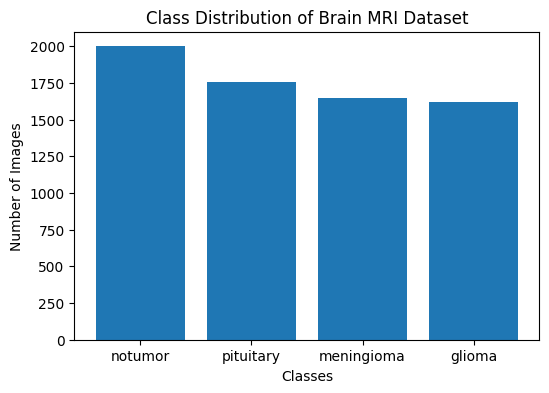

In [ ]:
# Plot class distribution (bar)
class_counts = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(classes.keys(), class_counts)
plt.title("Class Distribution of Brain MRI Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.show()


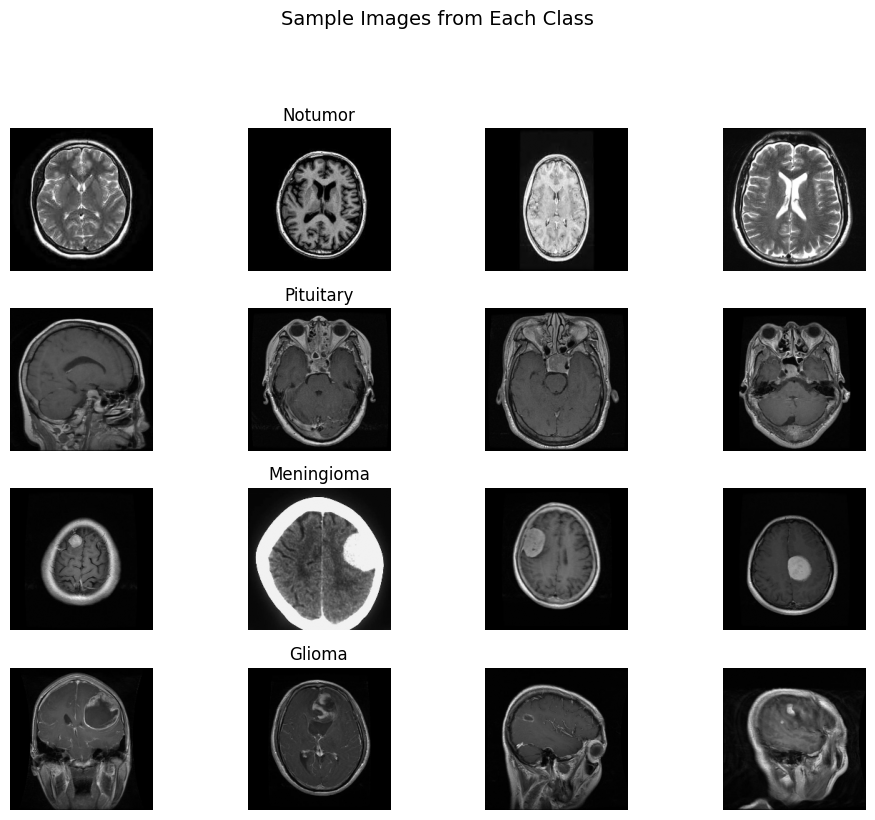

In [ ]:
# Show sample images (4 per class)
plt.figure(figsize=(10,8))
for idx, cls in enumerate(classes.keys()):
    imgs = x[y==classes[cls]][:4]
    for i in range(4):
        plt.subplot(len(classes), 4, idx*4 + i + 1)
        plt.imshow(imgs[i], cmap="gray")
        plt.axis("off")
        if i == 1:
            plt.title(cls.replace("_"," ").title(), fontsize=12)
plt.suptitle("Sample Images from Each Class", fontsize=14, x=0.5, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


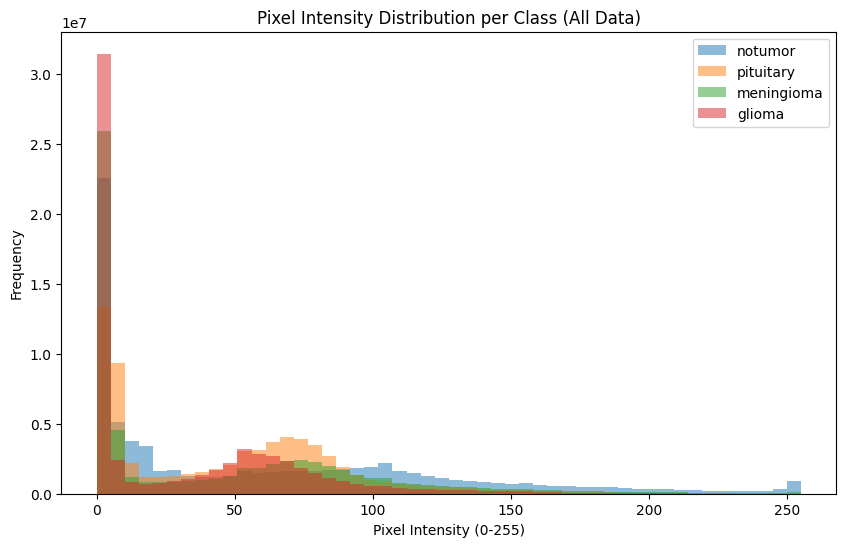

In [ ]:
# --- 4. Pixel Intensity Distribution (All classes together) ---
plt.figure(figsize=(10,6))
for cls, label in classes.items():
    pixels = x[y==label].ravel()
    plt.hist(pixels, bins=50, alpha=0.5, label=cls)
plt.title("Pixel Intensity Distribution per Class (All Data)")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


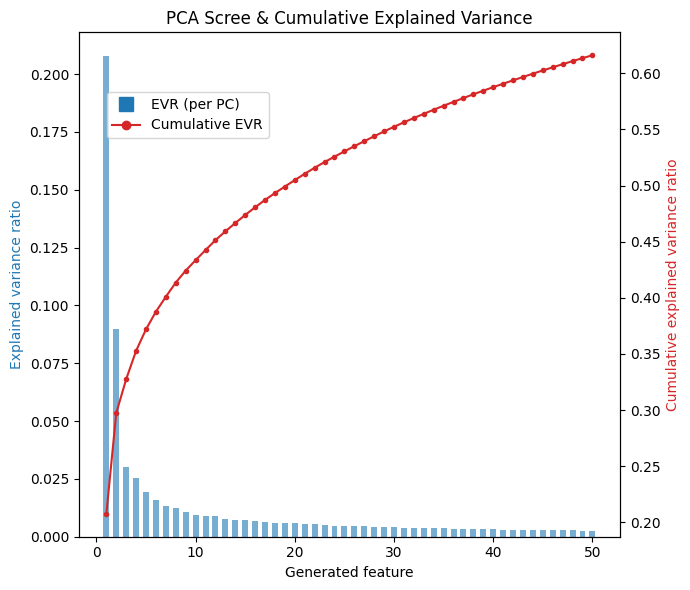

In [ ]:
# Plot scree (bars) and cumulative explained variance (line) using fitted PCA (compressed horizontally)
x_flat = x.reshape(len(x), -1) / 255.0
pca = PCA().fit(x_flat)
explained_var = np.cumsum(pca.explained_variance_ratio_)
evr_ratio = pca.explained_variance_ratio_

k = min(50, len(evr_ratio))
fig, ax1 = plt.subplots(figsize=(7,6))

ax1.bar(range(1, k+1), evr_ratio[:k], color="tab:blue", alpha=0.6, width=0.6, label="EVR (per PC)")
ax1.set_xlabel("Generated feature")
ax1.set_ylabel("Explained variance ratio", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(range(1, k+1), explained_var[:k], color="tab:red", marker="o", markersize=3, label="Cumulative EVR")
ax2.set_ylabel("Cumulative explained variance ratio", color="tab:red")

for thr in (0.90, 0.95, 0.98):
    j = int(np.searchsorted(explained_var, thr)) + 1
    if 1 <= j <= k:
        ax1.axvline(j, linestyle="--", alpha=0.6, color="gray")
        ax2.annotate(f"{thr*100:.0f}% → {j} comp",
                     xy=(j, explained_var[j-1]),
                     xytext=(j+1, min(0.99, explained_var[j-1] + 0.03)),
                     arrowprops=dict(arrowstyle="->", lw=1, color="gray"),
                     fontsize=9, color="black")

plt.title("PCA Scree & Cumulative Explained Variance")

bars_proxy = plt.Line2D([0],[0], color="tab:blue", marker="s", linestyle="",
                        markersize=10, label="EVR (per PC)")
line_proxy = plt.Line2D([0],[0], color="tab:red", marker="o", label="Cumulative EVR")

fig.legend(handles=[bars_proxy, line_proxy],
           loc="upper left",
           bbox_to_anchor=(0.15, 0.85))

plt.tight_layout()
plt.show()


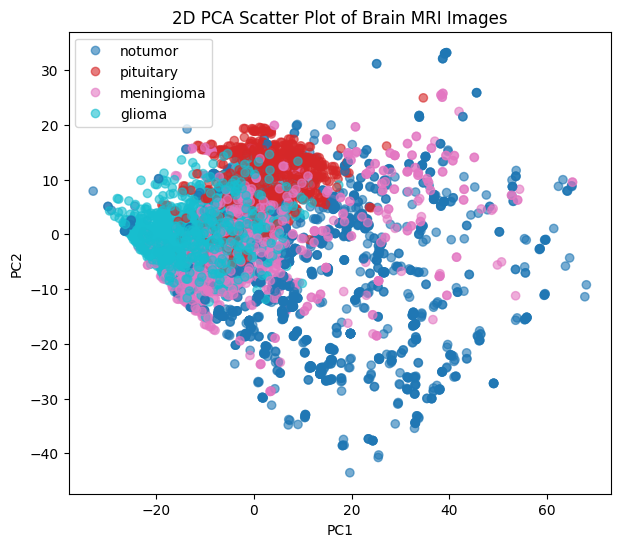

In [ ]:
# PCA 2D Scatter Plot
x = x.reshape(len(x), -1) / 255.0

pca2d = PCA(n_components=2).fit_transform(x)
plt.figure(figsize=(7,6))
scatter = plt.scatter(pca2d[:,0], pca2d[:,1], c=y, cmap="tab10", alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=classes.keys())
plt.title("2D PCA Scatter Plot of Brain MRI Images")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# SVM Preprocessing

In [ ]:
# Flatten images and normalize to [0,1]
X = x.reshape(len(x), -1) / 255.0
y = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (5618, 40000)  Test: (1405, 40000)


In [ ]:
# Fit PCA (98% variance) on training data only
pca = PCA(n_components=0.98, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("PCA Dimensions -> Train:", X_train_pca.shape, " Test:", X_test_pca.shape)

PCA Dimensions -> Train: (5618, 1944)  Test: (1405, 1944)


In [ ]:
# Apply StandardScaler (fit on training PCA output only)
scaler = StandardScaler()
X_train_pcs = scaler.fit_transform(X_train_pca)
X_test_pcs  = scaler.transform(X_test_pca)

# SVM Train&Evaluation

Test Accuracy: 0.8498220640569395
Test Balanced Acc: 0.8462528932520067
Test Precision (macro): 0.8514198299897285
Test Recall (macro): 0.8462528932520067
Test F1 (macro): 0.8455817216901986

Confusion matrix:
 [[367  29   2   2]
 [  5 300  10  37]
 [  1  19 241  68]
 [  1   7  30 286]]


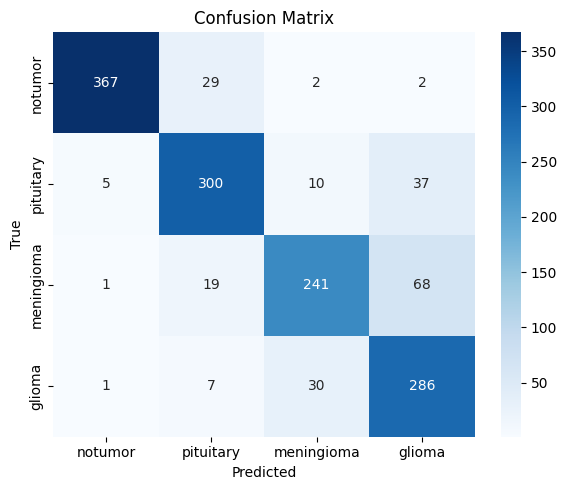

In [ ]:
# Train RBF-SVM and evaluate with accuracy, precision, recall, F1, and confusion matrix
clf = SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced", random_state=42)
clf.fit(X_train_pcs, y_train)

y_pred = clf.predict(X_test_pcs)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred))
print("Test Precision (macro):", precision_score(y_test, y_pred, average="macro"))
print("Test Recall (macro):", recall_score(y_test, y_pred, average="macro"))
print("Test F1 (macro):", f1_score(y_test, y_pred, average="macro"))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes.keys(),
            yticklabels=classes.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# CNN Preprocessing and Dataset Creation

In [ ]:
# Reproducibility and optional GPU memory configuration
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {len(gpus)}")
    except Exception as e:
        print("GPU memory growth ayarlanamadı:", e)


GPU detected: 1


In [ ]:
# Load grayscale images for CNN, normalize, split into train/test sets, and compute class weights
def load_images_for_cnn(folders, classes, size=(200, 200)):
    X_img, y_img = [], []
    for folder in folders:
        for cls_name, cls_id in classes.items():
            path = os.path.join(folder, cls_name)
            for img_name in os.listdir(path):
                img = cv2.imread(os.path.join(path, img_name), 0)  # grayscale
                img = cv2.resize(img, size)
                X_img.append(img)
                y_img.append(cls_id)
    X_img = np.array(X_img, dtype=np.float32) / 255.0
    X_img = X_img[..., np.newaxis]  # (N, H, W, 1)
    y_img = np.array(y_img, dtype=np.int64)
    return X_img, y_img

X_img, y_img = load_images_for_cnn(folders, classes, size=(200, 200))

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_img, y_img, test_size=0.2, stratify=y_img, random_state=42
)

num_classes = len(classes)
class_names = list(classes.keys())

cw = compute_class_weight(class_weight="balanced",
                          classes=np.unique(y_train_cnn),
                          y=y_train_cnn)
class_weights = {i: w for i, w in enumerate(cw)}

y_train_cat = tf.keras.utils.to_categorical(y_train_cnn, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test_cnn,  num_classes)

print("CNN train/test shapes:", X_train_cnn.shape, X_test_cnn.shape)
print("Class weights:", class_weights)


CNN train/test şekilleri: (5618, 200, 200, 1) (1405, 200, 200, 1)
Sınıf ağırlıkları: {0: np.float64(0.8778125), 1: np.float64(0.999644128113879), 2: np.float64(1.0672492401215805), 3: np.float64(1.0828835774865073)}


# Model and Trainer Creation

In [ ]:
# Define two CNN architectures: a lightweight SimpleCNN and a deeper variant (DeepCNN)
def build_simple_cnn(input_shape=(200, 200, 1), n_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return models.Model(inputs, outputs, name="SimpleCNN")


def build_deepcnn(input_shape=(200, 200, 1), n_classes=4):
    inputs = layers.Input(shape=input_shape)

    def block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        return layers.MaxPool2D()(x)

    # 5 convolutional blocks (deeper than the VGG-like baseline)
    x = block(inputs, 32)
    x = block(x, 64)
    x = block(x, 128)
    x = block(x, 256)
    x = block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return models.Model(inputs, outputs, name="DeepCNN")


In [ ]:
# Define training, evaluation, and visualization utilities for CNN experiments
# Define training, evaluation, and visualization utilities for CNN experiments
def train_and_eval(model, X_tr, y_tr, X_te, y_te, y_te_cat, class_weights, epochs=30, batch_size=32):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
    ]

    # Train and capture history
    history = model.fit(
        X_tr, y_tr,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # Plot training vs validation curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate model
    y_prob = model.predict(X_te, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    metrics = {
        "accuracy": accuracy_score(y_te, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_te, y_pred),
        "precision_macro": precision_score(y_te, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_te, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_te, y_pred, average="macro", zero_division=0),
        "confusion_matrix": confusion_matrix(y_te, y_pred)
    }
    return metrics, y_pred



def plot_cm(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


def to_row_dict(name, metrics):
    return {
        "Model": name,
        "Accuracy": metrics["accuracy"],
        "Balanced Acc": metrics["balanced_accuracy"],
        "Precision (macro)": metrics["precision_macro"],
        "Recall (macro)": metrics["recall_macro"],
        "F1 (macro)": metrics["f1_macro"],
    }


# CNN Train&Evaluation

Epoch 1/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.6105 - loss: 0.9211 - val_accuracy: 0.2260 - val_loss: 3.5364 - learning_rate: 0.0010
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7498 - loss: 0.6558 - val_accuracy: 0.2260 - val_loss: 5.8506 - learning_rate: 0.0010
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7874 - loss: 0.5546 - val_accuracy: 0.3310 - val_loss: 4.4235 - learning_rate: 0.0010
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8155 - loss: 0.4653 - val_accuracy: 0.4235 - val_loss: 2.7305 - learning_rate: 0.0010
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8449 - loss: 0.4132 - val_accuracy: 0.6673 - val_loss: 1.5907 - learning_rate: 0.0010
Epoch 6/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8488 - loss: 0.3774 - val_accuracy: 0.7811 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 7/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8704 - loss: 0

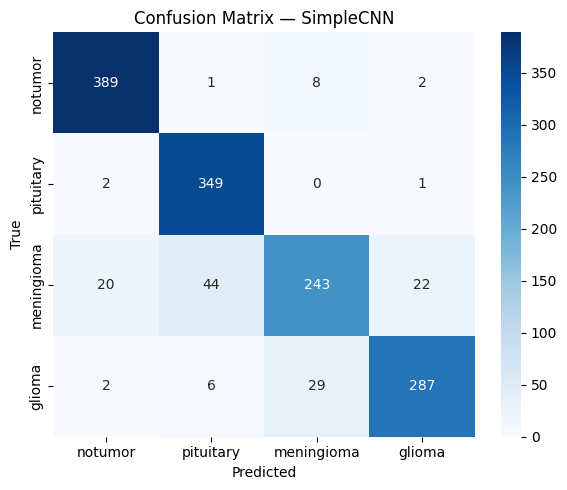

In [ ]:
# SimpleCNN
results = []

simple_cnn = build_simple_cnn(input_shape=X_train_cnn.shape[1:], n_classes=num_classes)
m_simple, y_pred_simple = train_and_eval(
    simple_cnn, X_train_cnn, y_train_cat, X_test_cnn, y_test_cnn, y_test_cat,
    class_weights, epochs=30, batch_size=32
)
plot_cm(m_simple["confusion_matrix"], class_names, "Confusion Matrix — SimpleCNN")
results.append(to_row_dict("SimpleCNN", m_simple))


Epoch 1/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - accuracy: 0.6538 - loss: 0.9586 - val_accuracy: 0.2260 - val_loss: 2.8419 - learning_rate: 0.0010
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7928 - loss: 0.5510 - val_accuracy: 0.2865 - val_loss: 3.6815 - learning_rate: 0.0010
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8247 - loss: 0.4700 - val_accuracy: 0.5071 - val_loss: 1.9740 - learning_rate: 0.0010
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8568 - loss: 0.3774 - val_accuracy: 0.7509 - val_loss: 0.7407 - learning_rate: 0.0010
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8770 - loss: 0.3182 - val_accuracy: 0.8416 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 6/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9028 - loss: 0.2846 - val_accuracy: 0.8897 - val_loss: 0.3292 - learning_rate: 0.0010
Epoch 7/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9264 - 

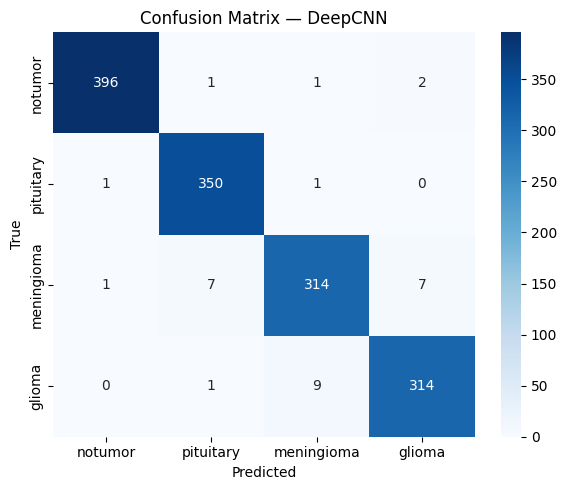

In [ ]:
# DeepCNN
deepcnn = build_deepcnn(input_shape=X_train_cnn.shape[1:], n_classes=num_classes)
m_deep, y_pred_deep = train_and_eval(
    deepcnn, X_train_cnn, y_train_cat, X_test_cnn, y_test_cnn, y_test_cat,
    class_weights, epochs=30, batch_size=32
)
plot_cm(m_deep["confusion_matrix"], class_names, "Confusion Matrix — DeepCNN")
results.append(to_row_dict("DeepCNN", m_deep))


# Comparison of Models

In [ ]:
# Create a comparison table including CNN and (if available) SVM results
import pandas as pd

def safe_add_svm(results_list):
    try:
        # Add SVM metrics if previous SVM variables (y_test, y_pred) exist
        svm_metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
            "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
            "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
            "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
        }
        results_list.append({
            "Model": "SVM (RBF + PCA98%)",
            "Accuracy": svm_metrics["accuracy"],
            "Balanced Acc": svm_metrics["balanced_accuracy"],
            "Precision (macro)": svm_metrics["precision_macro"],
            "Recall (macro)": svm_metrics["recall_macro"],
            "F1 (macro)": svm_metrics["f1_macro"],
        })
    except Exception:
        print("Note: SVM results could not be added (missing y_test/y_pred). Only CNN results are shown.")

safe_add_svm(results)

df_results = pd.DataFrame(results).sort_values(by="Balanced Acc", ascending=False)
print("\n=== Model Comparison ===")
display(df_results)



=== Model Comparison ===


,Model,Accuracy,Balanced Acc,Precision (macro),Recall (macro),F1 (macro)
1,DeepCNN,0.977936,0.976965,0.977049,0.976965,0.976972
0,SimpleCNN,0.902491,0.897095,0.900529,0.897095,0.896422
2,SVM (RBF + PCA98%),0.849822,0.846253,0.851420,0.846253,0.845582
